In [26]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import keras as ks
import tensorflow as tf
import pickle
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import keras
import random


In [27]:
!pip install -q -U tensorflow-addons

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [30]:
class Pairs:
  def makePairs(self, x, y):
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = list()
    labels = list()

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        labels += list([1])
        pairs += [[x1, x2]]
    
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        labels += list([0])
        pairs += [[x1, x2]]
        
    return np.array(pairs), np.array(labels)

In [4]:
digit_indices_train = [np.where(y_train == i)[0] for i in range(10)]
digit_indices_test = [np.where(y_test == i)[0] for i in range(10)]

tr_pairs, tr_y = create_pairs(x_train, digit_indices_train)
te_pairs, te_y = create_pairs(x_test, digit_indices_test)

In [43]:
p = Pairs()
pairs_train, labels_train = p.makePairs(x_train, y_train)
pairs_test, labels_test = p.makePairs(x_test, y_test)
labels_train = labels_train.astype('float32')
labels_test = labels_test.astype('float32')

In [48]:
margin = 1.0

In [53]:
def euclideanDistance(v):
    x, y = v
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_original, y_pred):
    sqaure_pred = K.square(y_pred)
    margin = 1.0
    margin_square = K.square(K.maximum(0.0, margin - y_pred))
    return K.mean(y_original * sqaure_pred + (1 - y_original) * margin_square)

def compute_accuracy(y_original, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_original)

def accuracy(y_original, y_pred):
    return K.mean(K.equal(y_original, K.cast(y_pred < 0.5, y_original.dtype)))

In [54]:
input = Input(shape=(784,))
x = Flatten()(input)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
dense = Model(input, x)


input1 = Input(shape=(784,))
input2 = Input(shape=(784,))
dense1 = dense(input1)
dense2 = dense(input2)

distance = Lambda(euclideanDistance, output_shape=eucl_dist_output_shape)([dense1, dense2])
model = Model([input1, input2], distance)


In [55]:
model.compile(loss = contrastive_loss, optimizer="adam", metrics=[accuracy])
model.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_39       │ (None, 256)       │     91,584 │ input_layer_20[0… │
│ (Functional)        │                   │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 1)         │          0 │ functional_39[0]… │
│                     │                   │            │ functional_39[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,584 (357.75 KB)

 Trainable params: 91,584 (357.75 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
 70/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5025 - loss: 0.1852

W0000 00:00:1709136676.245222      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5031 - loss: 0.0964

W0000 00:00:1709136679.452344      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709136680.299613      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5031 - loss: 0.0963 - val_accuracy: 0.5000 - val_loss: 0.0377
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5041 - loss: 0.0278 - val_accuracy: 0.5000 - val_loss: 0.0287
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5034 - loss: 0.0175 - val_accuracy: 0.5000 - val_loss: 0.0262
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5039 - loss: 0.0125 - val_accuracy: 0.5000 - val_loss: 0.0264
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5039 - loss: 0.0102 - val_accuracy: 0.5000 - val_loss: 0.0246
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5039 - loss: 0.0087 - val_accuracy: 0.5000 - val_loss: 0.0239
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5041 - loss: 0.0070 - val_accuracy: 0.5000 - val_loss: 0.0229
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5038 - loss: 0.0061 - val_accuracy: 0.5000 - val_

In [58]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)
print("Accuracy on test set:", te_acc*100)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy on test set: 97.0


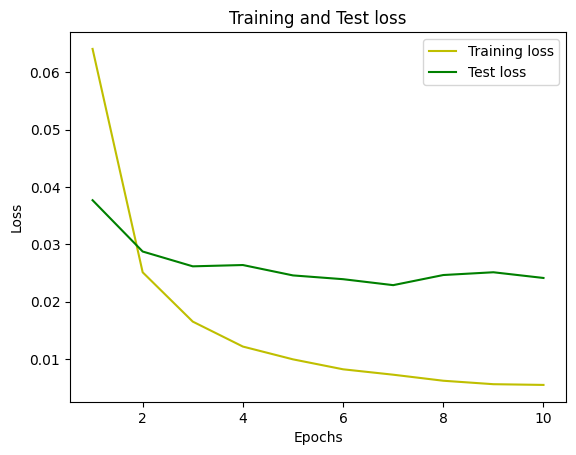

In [59]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()